--- 1. Re-creating Simulated Data for Analysis ---
Simulated dataset re-created with 1000 rows and 13 columns.
First 5 rows of the dataset:
   student_id  age  gender    region prior_education_level  enrollment_year  \
0           1   24  Female     Urban           High School             2021   
1           2   37    Male     Urban       Bachelor Degree             2023   
2           3   32  Female     Urban      Associate Degree             2022   
3           4   28  Female  Suburban           High School             2021   
4           5   25    Male     Rural      Associate Degree             2022   

   num_courses_enrolled  avg_prior_gpa  login_frequency_per_week  \
0                     2       2.453957                  7.065114   
1                     5       3.487810                  8.127800   
2                     2       3.838416                  2.651852   
3                     2       2.847540                  3.422656   
4                     2       2.684265       

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:33:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training complete.

--- 4. Evaluation ---

--- Evaluation on Validation Set ---
Classification Report (Validation Set):
              precision    recall  f1-score   support

    Retained       0.79      0.92      0.85       119
     Dropout       0.18      0.06      0.10        31

    accuracy                           0.75       150
   macro avg       0.49      0.49      0.47       150
weighted avg       0.67      0.75      0.70       150

F1-Score (Validation Set): 0.0952
AUC-ROC (Validation Set): 0.4996

--- Evaluation on Test Set (Final Assessment) ---
F1-Score (Test Set): 0.2500
AUC-ROC (Test Set): 0.6006

Classification Report (Test Set):
              precision    recall  f1-score   support

    Retained       0.82      0.96      0.88       120
     Dropout       0.50      0.17      0.25        30

    accuracy                           0.80       150
   macro avg       0.66      0.56      0.57       150
weighted avg       0.76      0.80      0.76       150



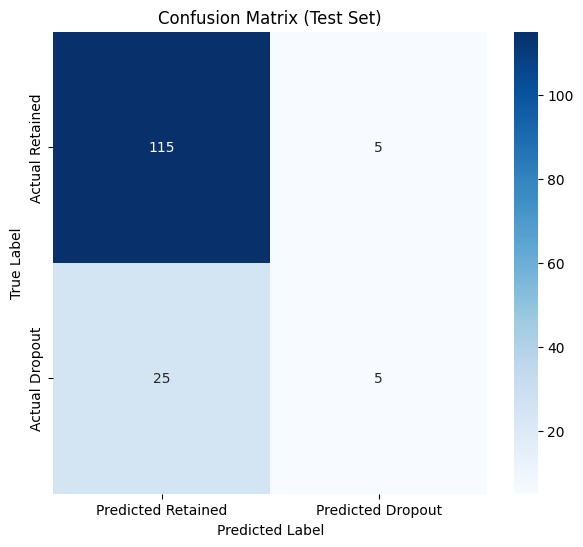

<Figure size 800x700 with 0 Axes>

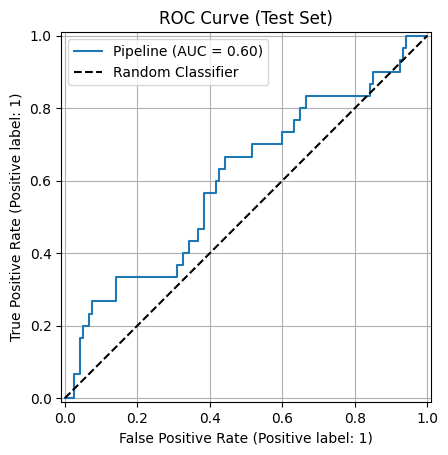


--- End of Analysis Script ---
This script demonstrates the end-to-end process from data generation to model evaluation.
The generated plots (Confusion Matrix, ROC Curve) will appear in your output.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- 1. Data Generation (Re-creating the Simulated Dataset) ---
# This section re-creates the 'df' DataFrame exactly as defined in the
# 'simulated-student-data' immersive artifact to ensure this script is self-contained and runnable.
# In a real scenario, you would load your data from a saved file (e.g., CSV, Parquet)
# or directly from a database.

print("--- 1. Re-creating Simulated Data for Analysis ---")

np.random.seed(42) # for reproducibility of numerical data
random.seed(42)   # for reproducibility of categorical choices

num_students = 1000 # Number of students in the dataset

# Simulate Demographic and Enrollment Data
genders = ['Male', 'Female', 'Non-binary']
regions = ['Urban', 'Suburban', 'Rural']
prior_education_levels = ['High School', 'Associate Degree', 'Bachelor Degree', 'Master Degree']

data = {
    'student_id': range(1, num_students + 1),
    'age': np.random.randint(18, 45, num_students),
    'gender': np.random.choice(genders, num_students, p=[0.48, 0.50, 0.02]),
    'region': np.random.choice(regions, num_students, p=[0.6, 0.3, 0.1]),
    'prior_education_level': np.random.choice(prior_education_levels, num_students, p=[0.3, 0.3, 0.2, 0.2]),
    'enrollment_year': np.random.randint(2020, 2024, num_students),
    'num_courses_enrolled': np.random.randint(1, 6, num_students),
    'avg_prior_gpa': np.random.uniform(2.0, 4.0, num_students)
}

# Simulate Learning Management System (LMS) Activity Data
data['login_frequency_per_week'] = np.random.normal(5, 2, num_students)
# Introduce missing values (5% of data points)
data['login_frequency_per_week'][np.random.choice(num_students, 50, replace=False)] = np.nan
data['assignment_submission_rate'] = np.random.uniform(0.5, 1.0, num_students)
data['forum_participation_score'] = np.random.normal(50, 15, num_students)
data['course_completion_rate_prev_term'] = np.random.uniform(0.6, 1.0, num_students)

# Simulate Target Variable: dropout_status
dropout_prob = (
    0.1 # Base probability
    + (data['age'] < 22) * 0.05
    + (data['login_frequency_per_week'] < 3) * 0.1
    + (data['assignment_submission_rate'] < 0.7) * 0.15
    + (data['prior_education_level'] == 'High School') * 0.05
    + (data['region'] == 'Rural') * 0.03
)
dropout_prob = np.clip(dropout_prob, 0.05, 0.3)

data['dropout_status'] = (np.random.rand(num_students) < dropout_prob).astype(int)

df = pd.DataFrame(data)

print(f"Simulated dataset re-created with {df.shape[0]} rows and {df.shape[1]} columns.")
print("First 5 rows of the dataset:")
print(df.head())
print("\nMissing values before preprocessing:")
print(df.isnull().sum())
print(f"\nOverall Dropout Rate: {df['dropout_status'].mean():.2%}")


# --- 2. Data Preprocessing & Feature Engineering ---
# This section implements the preprocessing steps outlined in the assignment:
# - Handling missing data
# - Feature Engineering
# - Normalization/Scaling
# - Encoding categorical features

print("\n--- 2. Data Preprocessing & Feature Engineering ---")

# Define numerical and categorical features based on the dataset
numerical_features = [
    'age', 'num_courses_enrolled', 'avg_prior_gpa',
    'login_frequency_per_week', 'assignment_submission_rate',
    'forum_participation_score', 'course_completion_rate_prev_term'
]
categorical_features = [
    'gender', 'region', 'prior_education_level', 'enrollment_year'
]

# --- Feature Engineering ---
# As proposed in the assignment, create a new composite feature.
# We'll fill NaNs for calculation, and then the imputer in the pipeline will handle them formally.
df['activity_engagement_score'] = (
    df['login_frequency_per_week'].fillna(df['login_frequency_per_week'].mean()) *
    df['forum_participation_score'].fillna(df['forum_participation_score'].mean())
) / 100 # Scaling factor to keep it in a reasonable range

# Add the newly engineered feature to the list of numerical features
numerical_features.append('activity_engagement_score')

# Separate features (X) and target variable (y)
X = df.drop(['student_id', 'dropout_status'], axis=1)
y = df['dropout_status']

# Create preprocessing pipelines for numerical and categorical features
# Numerical pipeline: Impute missing values with mean, then apply StandardScaler
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Handles missing data
    ('scaler', StandardScaler()) # Normalization/Scaling
])

# Categorical pipeline: One-hot encode categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Encoding categorical features
])

# Combine preprocessing steps using ColumnTransformer
# This applies the correct transformer to the correct set of columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocessing pipelines defined, including feature engineering for 'activity_engagement_score'.")


# --- 3. Model Development ---
# This section covers splitting the data and training the chosen model (XGBoost).

print("\n--- 3. Model Development ---")

# Split data into training, validation, and test sets
# A common split is 70% train, 15% validation, 15% test.
# stratify=y ensures that the proportion of dropout cases is maintained in each split,
# which is important for imbalanced datasets.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Data split into: Training ({X_train.shape[0]} samples), Validation ({X_val.shape[0]} samples), Test ({X_test.shape[0]} samples).")

# Choose a model: XGBoost Classifier
# Justification: XGBoost is a powerful ensemble method known for high accuracy on tabular data,
# handles various data types, and provides feature importance.
# Hyperparameters: n_estimators and learning_rate are two key hyperparameters to tune.
# - n_estimators: Controls the number of boosting rounds/trees. Tuning helps prevent under/overfitting.
# - learning_rate: Controls the step size at each iteration. Smaller values lead to more robust models.
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', XGBClassifier(objective='binary:logistic',
                                                              eval_metric='logloss', # Evaluation metric for training
                                                              use_label_encoder=False, # Suppress deprecation warning
                                                              random_state=42,
                                                              n_estimators=200, # Example initial value for tuning
                                                              learning_rate=0.05 # Example initial value for tuning
                                                              ))])

# Train the model using the training data
print("\nTraining the XGBoost model on the training set...")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")


# --- 4. Evaluation ---
# This section evaluates the trained model using relevant metrics and visualizations.

print("\n--- 4. Evaluation ---")

# Evaluate on the Validation Set first (as if for hyperparameter tuning)
print("\n--- Evaluation on Validation Set ---")
y_val_pred = model_pipeline.predict(X_val)
y_val_proba = model_pipeline.predict_proba(X_val)[:, 1] # Probability of the positive class (dropout)

print("Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=['Retained', 'Dropout']))

f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_proba)
print(f"F1-Score (Validation Set): {f1_val:.4f}")
print(f"AUC-ROC (Validation Set): {roc_auc_val:.4f}")


# Evaluate on the Unseen Test Set (Final Model Performance Assessment)
print("\n--- Evaluation on Test Set (Final Assessment) ---")
y_test_pred = model_pipeline.predict(X_test)
y_test_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class (dropout)

# Evaluation Metrics:
# 1. F1-Score: Harmonic mean of Precision and Recall. Relevant for imbalanced datasets
#    (like dropout prediction where retained students are more common) as it balances
#    identifying actual dropouts and avoiding false positives.
f1 = f1_score(y_test, y_test_pred)
print(f"F1-Score (Test Set): {f1:.4f}")

# 2. AUC-ROC: Area Under the Receiver Operating Characteristic Curve. Measures the model's
#    ability to distinguish between positive and negative classes across all possible
#    classification thresholds. A higher value indicates better overall performance.
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"AUC-ROC (Test Set): {roc_auc:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Retained', 'Dropout']))

# --- Visualization of Confusion Matrix ---
# Helps to visualize True Positives, False Positives, True Negatives, False Negatives.
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Retained', 'Predicted Dropout'],
            yticklabels=['Actual Retained', 'Actual Dropout'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- Visualization of ROC Curve ---
# Shows the trade-off between True Positive Rate (Recall) and False Positive Rate.
plt.figure(figsize=(8, 7))
RocCurveDisplay.from_estimator(model_pipeline, X_test, y_test)
plt.title('ROC Curve (Test Set)')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier') # Baseline for random guessing
plt.legend()
plt.grid(True)
plt.show()

print("\n--- End of Analysis Script ---")
print("This script demonstrates the end-to-end process from data generation to model evaluation.")
print("The generated plots (Confusion Matrix, ROC Curve) will appear in your output.")